In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [2]:
neg_img, neg_name = load_data('test', 'n', 'neg', data = 'sm_v2', extract_name = True)
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm_v2', extract_name = True)
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm_v2', extract_name = True)
active_img, active_name = load_data('test', 'h', 'active', data = 'sm_v2', extract_name = True)
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm_v2', extract_name = True)
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm_v2', extract_name = True)
str_img, str_name = load_data('test', 'd', 'str', data = 'sm_v2', extract_name = True)

In [3]:
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (10927, 512, 512, 3) (10927, 2)
red spot: (973, 512, 512, 3) (973, 2)
angioectasia: (35, 512, 512, 3) (35, 2)
active_bleeding: (756, 512, 512, 3) (756, 2)
erosion: (1295, 512, 512, 3) (1295, 2)
ulcer: (1281, 512, 512, 3) (1281, 2)
stricture: (182, 512, 512, 3) (182, 2)


In [4]:
len(redspot_name) + len(angio_name) + len(active_name)

1764

In [5]:
len(ero_name) + len(ulcer_name) + len(str_name)

2758

In [6]:
len(redspot_name) + len(angio_name) + len(active_name) + len(ero_name) + len(ulcer_name) + len(str_name)

4522

In [7]:
np.random.choice(len(neg_name), 4522)

array([1771, 7922, 7227, ...,  154,  758, 7964])

In [8]:
neg2_img = neg_img[np.random.choice(len(neg_name), 4522)]
neg2_label = one_hot(neg2_img, 0)

In [9]:
neg2_img.shape

(4522, 512, 512, 3)

# Model Inference

In [92]:
nh_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'NH_' in i and 'core' not in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'ND_' in i and 'core' not in i])
b_list = sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'B_' in i and 'core' not in i])

In [52]:
nh_list

['NH_1908312018_5750_val_acc_1.00_val_loss_0.001598',
 'NH_2001060148_2540_val_acc_1.00_val_loss_0.034387',
 'NH_2001060150_2870_val_acc_0.98_val_loss_0.027345',
 'NH_2001060155_3730_val_acc_1.00_val_loss_0.015424',
 'NH_2001060204_5320_val_acc_1.00_val_loss_0.009253',
 'NH_2001060208_6000_val_acc_1.00_val_loss_0.005527',
 'NH_2001062352_20490_val_acc_1.00_val_loss_0.000032',
 'NH_2001070020_23020_val_acc_1.00_val_loss_0.000018',
 'NH_2001070150_5800_val_acc_0.98_val_loss_0.043403',
 'NH_2001070151_5900_val_acc_0.98_val_loss_0.038373',
 'NH_2001070214_8200_val_acc_1.00_val_loss_0.035504',
 'NH_2001070221_8900_val_acc_0.99_val_loss_0.023356',
 'NH_2001080155_12800_val_acc_0.99_val_loss_0.016635',
 'NH_2001081600_2000_val_acc_0.97_val_loss_0.093729',
 'NH_2001081601_2100_val_acc_0.97_val_loss_0.057087',
 'NH_2001081619_3800_val_acc_0.97_val_loss_0.054612',
 'NH_2001081626_4500_val_acc_0.98_val_loss_0.046558',
 'NH_2001081636_5500_val_acc_0.99_val_loss_0.035910',
 'NH_2001100009_520_val_a

In [93]:
nd_list

['ND_1908302155_7140_val_acc_1.00_val_loss_0.002939',
 'ND_2001062348_20190_val_acc_1.00_val_loss_0.002604',
 'ND_2001062355_20780_val_acc_1.00_val_loss_0.001135',
 'ND_2001070006_21740_val_acc_1.00_val_loss_0.000432',
 'ND_2001070141_4900_val_acc_0.96_val_loss_0.124103',
 'ND_2001070150_5800_val_acc_0.96_val_loss_0.120055',
 'ND_2001070152_6000_val_acc_0.97_val_loss_0.106324',
 'ND_2001070211_7800_val_acc_0.96_val_loss_0.104963',
 'ND_2001070212_7900_val_acc_0.97_val_loss_0.058071',
 'ND_2001081614_2700_val_acc_0.95_val_loss_0.130868',
 'ND_2001081615_2800_val_acc_0.96_val_loss_0.113698',
 'ND_2001081634_4700_val_acc_0.95_val_loss_0.104473',
 'ND_2001081639_5200_val_acc_0.97_val_loss_0.078812',
 'ND_2001081650_6300_val_acc_0.98_val_loss_0.049867',
 'ND_2001100010_10_val_acc_0.50_val_loss_0.691652',
 'ND_2001100010_50_val_acc_0.48_val_loss_0.690351',
 'ND_2001100011_60_val_acc_0.47_val_loss_0.679513',
 'ND_2001100011_70_val_acc_0.65_val_loss_0.657932',
 'ND_2001100011_90_val_acc_0.67_v

In [95]:
sorted([i[:-5] for i in os.listdir('./model') if 'meta' in i and 'N1D9_' in i and 'core' not in i])

['N1D9_2001100152_4380_val_acc_0.98_val_loss_0.039794',
 'N1D9_2001100202_4900_val_acc_0.99_val_loss_0.039726',
 'N1D9_2001100204_4990_val_acc_0.99_val_loss_0.027827',
 'N1D9_2001100206_5120_val_acc_0.99_val_loss_0.026593',
 'N1D9_2001100219_5810_val_acc_0.99_val_loss_0.022532']

In [54]:
b_list

['B_2001060434_9410_val_acc_1.00_val_loss_0.019657',
 'B_2001060441_9870_val_acc_1.00_val_loss_0.011613',
 'B_2001060509_11910_val_acc_1.00_val_loss_0.009551',
 'B_2001060518_12540_val_acc_1.00_val_loss_0.008383',
 'B_2001060534_13690_val_acc_1.00_val_loss_0.006853',
 'B_2001081714_6900_val_acc_0.96_val_loss_0.094075',
 'B_2001081734_8800_val_acc_0.97_val_loss_0.077247',
 'B_2001081739_9300_val_acc_0.98_val_loss_0.059156',
 'B_2001081801_11400_val_acc_0.98_val_loss_0.050810',
 'B_2001081821_13300_val_acc_0.98_val_loss_0.042233',
 'B_2001100012_80_val_acc_0.60_val_loss_0.659025',
 'B_2001100013_150_val_acc_0.66_val_loss_0.650705',
 'B_2001100013_90_val_acc_0.57_val_loss_0.655705',
 'B_2001100014_160_val_acc_0.64_val_loss_0.616498',
 'B_2001100014_180_val_acc_0.68_val_loss_0.614124',
 'B_2001100015_10_val_acc_0.50_val_loss_0.691157',
 'B_2001100015_30_val_acc_0.62_val_loss_0.688692',
 'B_2001100015_50_val_acc_0.64_val_loss_0.606388',
 'B_2001100122_3070_val_acc_1.00_val_loss_0.034832',
 

In [55]:
nh_path = './model/' + 'NH_2001062207_10900_val_acc_1.00_val_loss_0.000584'
nd_path = './model/' + 'ND_2001060354_8430_val_acc_1.00_val_loss_0.009623'
b_path = './model/' + 'B_2001060534_13690_val_acc_1.00_val_loss_0.006853'

nh_path = './model/' + 'NH_2001080155_12800_val_acc_0.99_val_loss_0.016635'
nd_path = './model/' + 'ND_2001070006_21740_val_acc_1.00_val_loss_0.000432'
b_path = './model/' + 'B_2001080202_18300_val_acc_0.99_val_loss_0.026502'

nh_path = './model/' + 'NH_2001081636_5500_val_acc_0.99_val_loss_0.035910'
nd_path = './model/' + 'ND_2001081650_6300_val_acc_0.98_val_loss_0.049867'
b_path = './model/' + 'B_2001081821_13300_val_acc_0.98_val_loss_0.042233'

nh_path = './model/' + nh_list[-1]
nd_path = './model/' + nd_list[-1]
b_path = './model/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

In [96]:
n1d9_path = './model/' + 'N1D9_2001100219_5810_val_acc_0.99_val_loss_0.022532'

N1D9_model = binary_model(n1d9_path)

In [97]:
neg_n1d9_output = model_prob(N1D9_model, neg_img)
redspot_n1d9_output = model_prob(N1D9_model, redspot_img)
angio_n1d9_output = model_prob(N1D9_model, angio_img)
active_n1d9_output = model_prob(N1D9_model, active_img)
ero_n1d9_output = model_prob(N1D9_model, ero_img)
ulcer_n1d9_output = model_prob(N1D9_model, ulcer_img)
str_n1d9_output  = model_prob(N1D9_model, str_img)

#: 10927 / Inference Time: 00:00:52
#: 973 / Inference Time: 00:00:04
#: 35 / Inference Time: 00:00:00
#: 756 / Inference Time: 00:00:03
#: 1295 / Inference Time: 00:00:06
#: 1281 / Inference Time: 00:00:06
#: 182 / Inference Time: 00:00:00


In [56]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

#: 10927 / Inference Time: 00:01:43
#: 973 / Inference Time: 00:00:09
#: 35 / Inference Time: 00:00:00
#: 756 / Inference Time: 00:00:07
#: 1295 / Inference Time: 00:00:12
#: 1281 / Inference Time: 00:00:12
#: 182 / Inference Time: 00:00:01


In [57]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

#: 10927 / Inference Time: 00:00:52
#: 973 / Inference Time: 00:00:04
#: 35 / Inference Time: 00:00:00
#: 756 / Inference Time: 00:00:03
#: 1295 / Inference Time: 00:00:06
#: 1281 / Inference Time: 00:00:06
#: 182 / Inference Time: 00:00:00


In [58]:
neg2_e_output, neg2_nh_output, neg2_nd_output = model_prob(E_model, neg2_img, model_type = 'ensemble')
neg2_b_output = model_prob(B_model, neg2_img)

#: 4522 / Inference Time: 00:00:43
#: 4522 / Inference Time: 00:00:21


# Evaluation

In [59]:
cls = classification_metric()

## Accuracy per lesion

In [60]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 97.93 %
Accuracy: 90.96 %
Accuracy: 100.00 %
Accuracy: 98.54 %


In [61]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 98.01 %
Accuracy: 94.90 %
Accuracy: 95.47 %
Accuracy: 87.91 %


In [98]:
neg_n1d9_acc = cls.accuracy(neg_label, neg_n1d9_output)
ero_n1d9_acc = cls.accuracy(ero_label, ero_n1d9_output)
ulcer_n1d9_acc = cls.accuracy(ulcer_label, ulcer_n1d9_output)
str_n1d9_acc = cls.accuracy(str_label, str_n1d9_output)

Accuracy: 90.99 %
Accuracy: 96.83 %
Accuracy: 97.11 %
Accuracy: 91.21 %


In [62]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 97.55 %
Accuracy: 87.67 %
Accuracy: 100.00 %
Accuracy: 98.15 %
Accuracy: 93.90 %
Accuracy: 92.51 %
Accuracy: 90.66 %


In [63]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 96.37 %
Accuracy: 92.29 %
Accuracy: 100.00 %
Accuracy: 99.60 %
Accuracy: 96.45 %
Accuracy: 96.88 %
Accuracy: 93.41 %


In [64]:
neg2_nh_acc = cls.accuracy(neg2_label, neg2_nh_output)
neg2_nd_acc = cls.accuracy(neg2_label, neg2_nd_output)
neg2_b_acc = cls.accuracy(neg2_label, neg2_b_output)
neg2_e_acc = cls.accuracy(neg2_label, neg2_e_output)

Accuracy: 97.97 %
Accuracy: 98.03 %
Accuracy: 97.88 %
Accuracy: 96.46 %


## Confusion Matrix

In [65]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

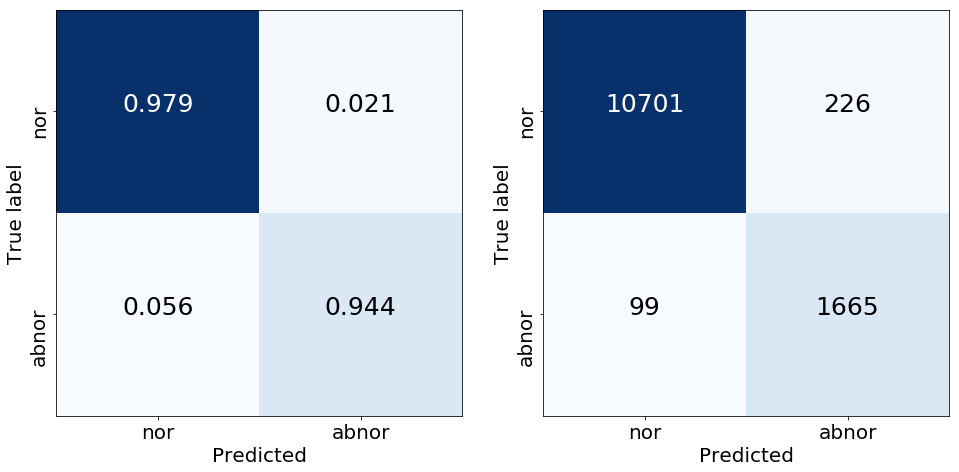

In [102]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [67]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

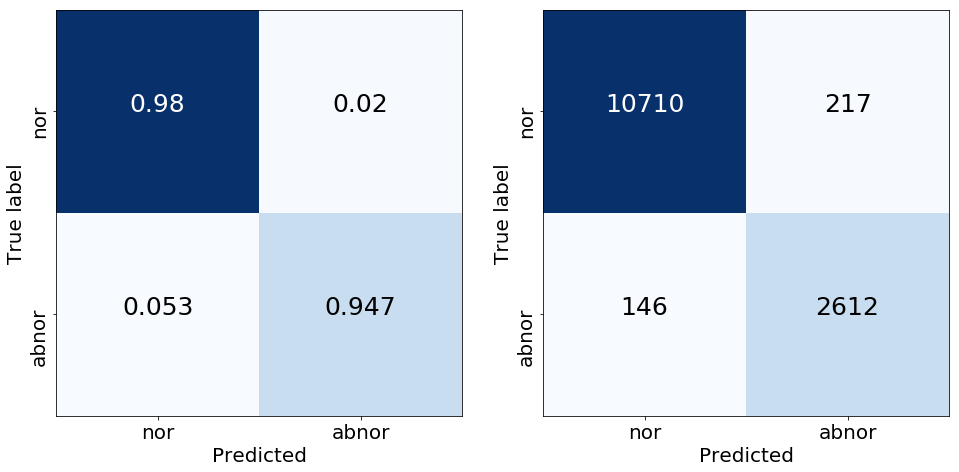

In [101]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [69]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

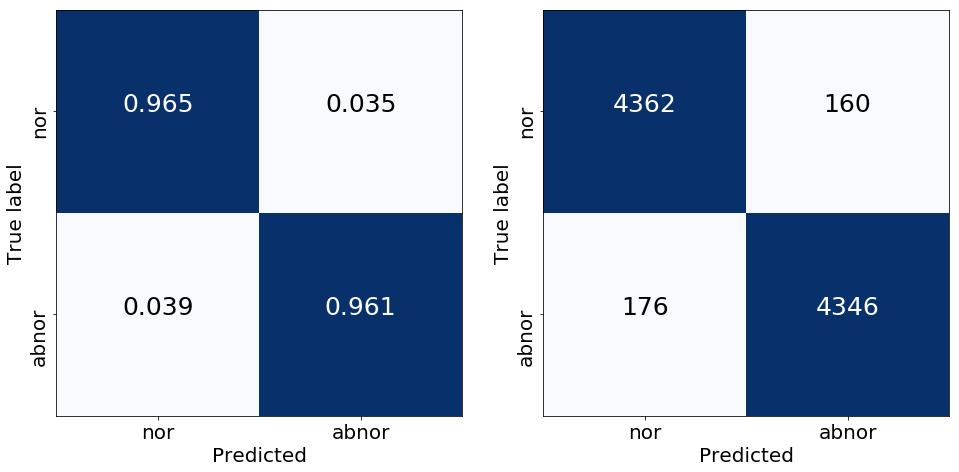

In [100]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [71]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

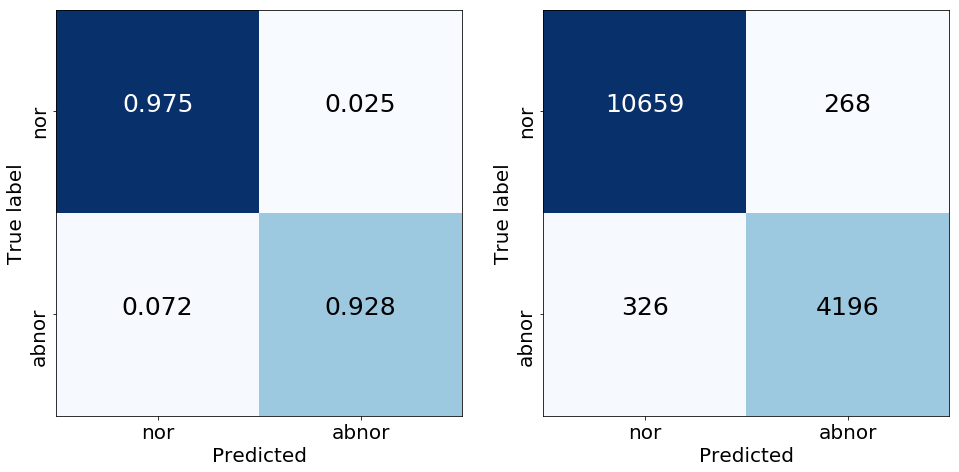

In [72]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

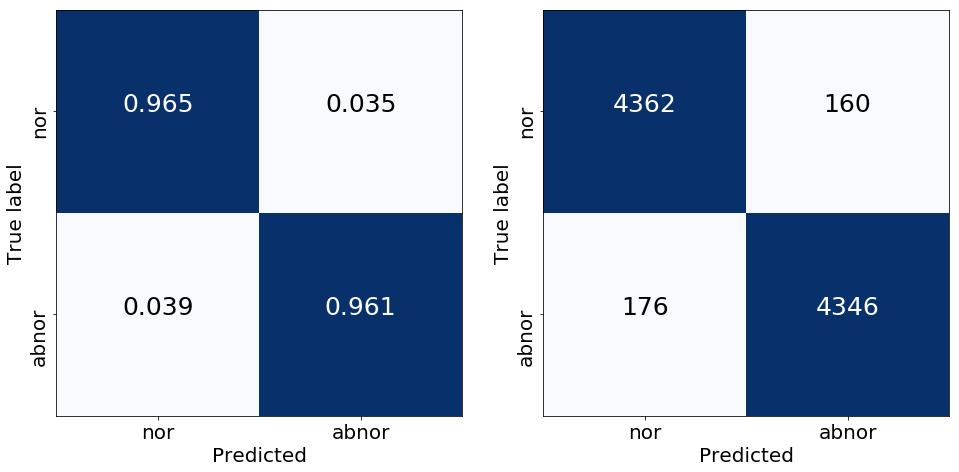

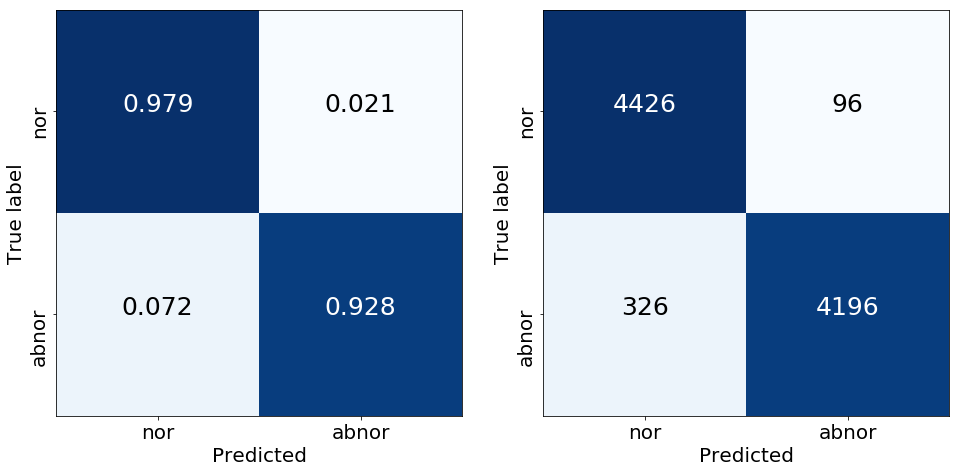

In [99]:
e_outputs = np.vstack([neg2_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

b_outputs = np.vstack([neg2_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg2_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## ROC curve

In [74]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [75]:
from sklearn.model_selection import KFold

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [76]:
n_g = 10

_, neg2_idxs = k_fold_idx(n_fold = n_g, dataset = neg2_label)
_, redspot_idxs = k_fold_idx(n_fold = n_g, dataset = redspot_label)
_, angio_idxs = k_fold_idx(n_fold = n_g, dataset = angio_label)
_, active_idxs = k_fold_idx(n_fold = n_g, dataset = active_label)
_, ero_idxs = k_fold_idx(n_fold = n_g, dataset = ero_label)
_, ulcer_idxs = k_fold_idx(n_fold = n_g, dataset = ulcer_label)
_, str_idxs = k_fold_idx(n_fold = n_g, dataset = str_label)

In [77]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


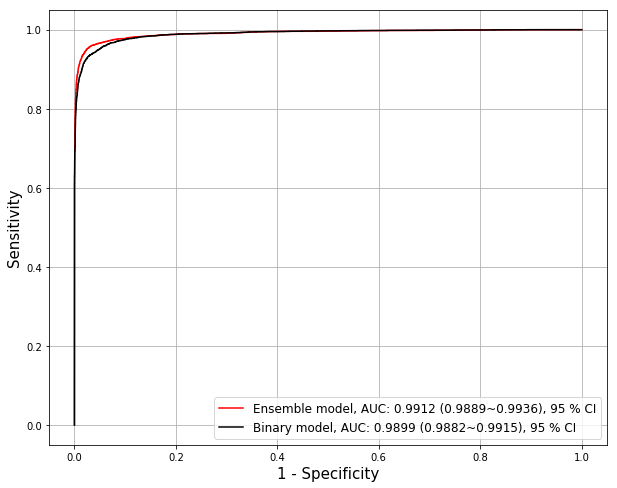

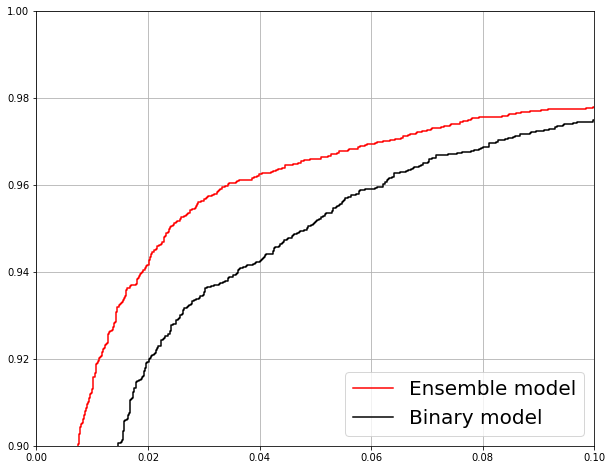

In [78]:
e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [79]:
e_CM, b_CM = [], []

for n_idx, r_idx, an_idx, ac_idx, e_idx, u_idx, s_idx in zip(neg2_idxs, redspot_idxs, angio_idxs, active_idxs,
                                                               ero_idxs, ulcer_idxs, str_idxs):
    
    b_outputs = np.vstack([neg2_b_output[n_idx], redspot_b_output[r_idx], angio_b_output[an_idx], active_b_output[ac_idx], 
                           ero_b_output[e_idx], ulcer_b_output[u_idx], str_b_output[s_idx]])
    e_outputs = np.vstack([neg2_e_output[n_idx], redspot_e_output[r_idx], angio_e_output[an_idx], active_e_output[ac_idx], 
                           ero_e_output[e_idx], ulcer_e_output[u_idx], str_e_output[s_idx]])
    labels = np.vstack([neg2_label[n_idx], redspot_label[r_idx], angio_label[an_idx], active_label[ac_idx], 
                        ero_label[e_idx], ulcer_label[u_idx], str_label[s_idx]])
    print(labels.shape)
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

(909, 2)
(908, 2)
(906, 2)
(905, 2)
(905, 2)
(903, 2)
(902, 2)
(902, 2)
(902, 2)
(902, 2)


In [80]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [81]:
b_metrices

array([[0.9559956 , 0.92982456, 0.98233996, 0.93291405, 0.98148148],
       [0.95154185, 0.92527473, 0.97792494, 0.92872117, 0.97679814],
       [0.95584989, 0.92951542, 0.98230088, 0.93277311, 0.98139535],
       [0.95801105, 0.93377483, 0.98230088, 0.93670886, 0.98143852],
       [0.95690608, 0.92935982, 0.98451327, 0.93291405, 0.98364486],
       [0.95791805, 0.94235033, 0.97345133, 0.94420601, 0.97254005],
       [0.96341463, 0.94444444, 0.98230088, 0.9466951 , 0.98152425],
       [0.95343681, 0.93333333, 0.97345133, 0.93617021, 0.97222222],
       [0.93237251, 0.88666667, 0.97787611, 0.89655172, 0.97555012],
       [0.94789357, 0.92444444, 0.97123894, 0.92811839, 0.96969697]])

In [82]:
e_metrices

array([[0.97029703, 0.97807018, 0.96247241, 0.97757848, 0.96328294],
       [0.96035242, 0.95384615, 0.96688742, 0.95424837, 0.96659243],
       [0.97130243, 0.969163  , 0.97345133, 0.969163  , 0.97345133],
       [0.96353591, 0.95364238, 0.97345133, 0.95444685, 0.97297297],
       [0.96243094, 0.96467991, 0.96017699, 0.96444444, 0.96043956],
       [0.96124031, 0.96674058, 0.95575221, 0.96644295, 0.95614035],
       [0.97117517, 0.97333333, 0.96902655, 0.97333333, 0.96902655],
       [0.96452328, 0.96444444, 0.96460177, 0.96460177, 0.96444444],
       [0.94567627, 0.92888889, 0.96238938, 0.93147752, 0.96091954],
       [0.9578714 , 0.95777778, 0.9579646 , 0.9579646 , 0.95777778]])

In [83]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 95.33 (94.73 ~ 95.94)
Sen --- 92.79 (91.65 ~ 93.93)
Spec --- 97.88 (97.54 ~ 98.21)
NPV --- 93.16 (92.18 ~ 94.14)
PPV --- 97.76 (97.41 ~ 98.11)

Ensemble model
Accr --- 96.28 (95.74 ~ 96.83)
Sen --- 96.11 (95.12 ~ 97.09)
Spec --- 96.46 (96.03 ~ 96.90)
NPV --- 96.14 (95.21 ~ 97.07)
PPV --- 96.45 (96.02 ~ 96.88)


### Equal-Variance Test

In [84]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 0.082, pvalue=0.774398477253
bartlett test for sensitivity: 0.169, pvalue=0.681068134647
bartlett test for specificity: 0.569, pvalue=0.450603302773
bartlett test for negative predictive values: 0.024, pvalue=0.875777684246
bartlett test for positive predictive values: 0.326, pvalue=0.568104065227


In [85]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 0.006, pvalue=0.940178461841
levene test for sensitivity: 0.009, pvalue=0.926476579561
levene test for specificity: 0.427, pvalue=0.521810470864
levene test for negative predictive values: 0.056, pvalue=0.816411280080
levene test for positive predictive values: 0.161, pvalue=0.693251854843


### Normality Test

In [86]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 0.700, pvalue=0.012340600576
Kolmogorov-Smirnov test for sensitivity: 0.900, pvalue=0.000216501764
Kolmogorov-Smirnov test for specificity: 0.800, pvalue=0.002056766763
Kolmogorov-Smirnov test for negative predictive values: 0.900, pvalue=0.000216501764
Kolmogorov-Smirnov test for positive predictive values: 0.800, pvalue=0.002056766763


### Wilcoxon signed-ranks test (not normal and paired group)

In [87]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.005033508201
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.004920313984
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


### Paired two-sample t-Test (normal and paired group)

In [88]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: -7.389, pvalue=0.000041508778
t-statistics for sensitivity: -12.305, pvalue=0.000000621560
t-statistics for specificity: 8.554, pvalue=0.000012910384
t-statistics for negative predictive values: -12.318, pvalue=0.000000615916
t-statistics for positive predictive values: 8.248, pvalue=0.000017323716


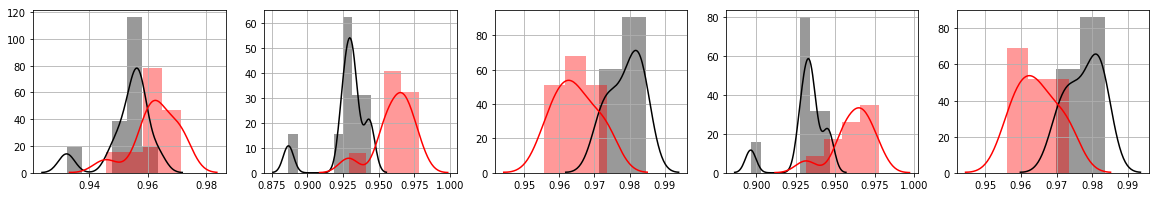

In [89]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()